# Linear Regression and Model Selection on Advertising Data
Let's take a look at some advertising data, and then fill in the missing code using the provided hints and answer the questions in 1-2 sentences (Each ... indicates missing code or answer).

What are the **features**?
- TV: advertising dollars spent on TV for a single product in a given market (in thousands of dollars)
- Radio: advertising dollars spent on Radio 1
- Radio 2: advertising dollars spent on Radio 2
- Newspaper: advertising dollars spent on Newspaper
- Area: the location

What is the **response**?
- Sales: sales of a single product in a given market (in thousands of widgets)

There are 200 **observations**, and thus 200 markets in the dataset.

In [40]:
# imports
import pandas as pd
import numpy as np

##fill in the missing code to read data into a DataFrame using read_csv in pandas package
data = pd.read_csv('advertising.csv', index_col=0)
data = data.dropna()
data.head()

,TV,radio,radio_2,newspaper,area,sales
1,230.1,37.8,75.6,69.2,rural,22.1
2,44.5,39.3,78.6,45.1,urban,10.4
3,17.2,45.9,91.8,69.3,rural,9.3
4,151.5,41.3,82.6,58.5,urban,18.5
5,180.8,10.8,21.6,58.4,suburban,12.9


## Fitting the data to a Linear model (4 pts)
Let's try to fitting a linear regression model immediately to the given dataset

In [41]:
from sklearn.linear_model import LinearRegression

##fill in the feature list
feature_cols = ['TV','radio','radio_2','newspaper','area']
X = data[feature_cols].values
y = data.sales.values

## instantiate a Linear Regression model and fit to the data
model = LinearRegression()
model.fit(X, y)
# print coefficients
print(feature_cols, model.coef_)

ValueError: could not convert string to float: 'rural'

**Question**: What is the output of this first attempt to fit a Linear Regression model? Explain the output in 1-2 sentences.

***It causes error saying 'could not convert string to float: 'rural''. It is because the feature 'area' is categorical and the model cannot handle non-numerical values.***

## Handling Categorical Features via One-Hot Encoding (4 pts)

We have to represent **area** numerically, but we can't simply code it as 0=rural, 1=suburban, 2=urban because that would imply an **ordered relationship** between suburban and urban (and thus urban is somehow "twice" the suburban category).

**Question:** How many variables need to be created and why? 

***3 - is_rural, is_suburban, is_urban*** ...

**Question:** Intepret the encoding

- **rural** is coded as 1, 0, 0
- **suburban** is coded as 0, 1, 0
- **urban** is coded as 0, 0, 1

In [42]:
## create three dummy variables using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(data['area']).iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
data = pd.concat([data, area_dummies], axis=1)
data.head()

,TV,radio,radio_2,newspaper,area,sales,suburban,urban
1,230.1,37.8,75.6,69.2,rural,22.1,0,0
2,44.5,39.3,78.6,45.1,urban,10.4,0,1
3,17.2,45.9,91.8,69.3,rural,9.3,0,0
4,151.5,41.3,82.6,58.5,urban,18.5,0,1
5,180.8,10.8,21.6,58.4,suburban,12.9,1,0


Let's include the new dummy variables in the model:

In [43]:
## your new list of features
feature_cols = ['TV', 'radio', 'radio_2', 'newspaper', 'suburban', 'urban']
X = data[feature_cols].values

from sklearn import preprocessing

## Min max feature scaling using MinMaxScaler from sklearn
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

## instantiate, fit
model = LinearRegression()
model.fit(X, y)

# print coefficients
print(feature_cols, model.coef_)

['TV', 'radio', 'radio_2', 'newspaper', 'suburban', 'urban'] [13.54373938  4.6528972   4.6528972  -0.11576352 -0.1178903   0.25352196]


**Question:** Holding all other variables fixed, how do we interpret the coefficients of dummy variables?
- Being a **suburban** area is associated with an average of 0.1179 decrease in sales.
- Being an **urban** area is associated with an average of 0.2535 increase in sales.

**Question:** What are the coefficients of radio and radio_2 features are look like? How does it possibly happen (1-2 sentences)?

**Coefficients of radio and radio_2 are both 4.6528972. It could be the two features have collinearity. They are correlated with each other**

## Handling Collinearity using VIF (4 pts)

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## use variance_inflation_factor to compute VIF scores for the features 
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif)

[2.8283216335767447, inf, inf, 3.0846681025604923, 1.7721591778172379, 1.6887602573497231]


/anaconda3/lib/python3.6/site-packages/statsmodels-0.10.0.dev0+819.gb858e6e58-py3.6-macosx-10.7-x86_64.egg/statsmodels/stats/outliers_influence.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


**Question:** Based on the VIF values, what features are collinear and what features can we remove to elimiate collinearity?

***radio and radio_2 are collinear. So we can remove radio_2 to eliminate collinearity***

Recompute VIF scores after removing that feature


In [45]:
## Your new list of features after removing collinear features
feature_cols = ['TV', 'radio','newspaper','suburban','urban']
X = data[feature_cols].values

## Min max feature scaling
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

## Compute VIF scores for all remaining features
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif)

[2.8283216335767456, 3.519459817796587, 3.0846681025604923, 1.7721591778172379, 1.688760257349723]


**Question:** How do the VIF scores for these fetures look like?

***The VIF scores look reasonable now, all VIF scores are < 5, which shows that there is no significant collinearity between features. *** 

## Handling Ourliers (4 pts)
Let's try to identify ourliers from our dataset using residual plot and seaborn package

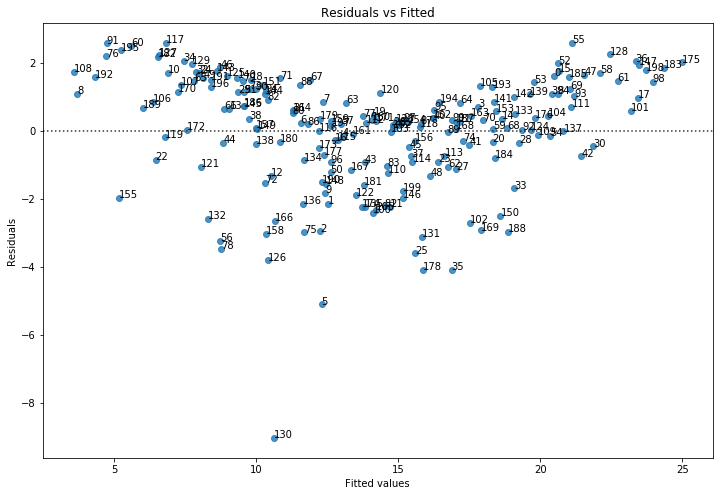

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

## instantiate, fit a linear regression model
model = LinearRegression()
model.fit(X, y)
## compute predicted values and residuals
y_pred = model.predict(X)
y_resid = y - y_pred

plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

## use residplot from seaborn to draw the residual plot
plot_lm_1.axes[0] = sns.residplot(y_pred, y_resid)

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
for i in range(len(y)):
    plot_lm_1.axes[0].annotate(i, 
                               xy=(y_pred[i], 
                                   y_resid[i]));

**Question:** Find the point with highest residual and remove it from the data. Retrain the model and draw the residual plot again to confirm that the outlier has been removed

## Linear Regression and GridSearchCV Model Selection in scikit-learn (4 pts)

Let's fit a Linear Regression model with ridge regularization and do model selection to select regularization constant. Fill in the missing code using the hints

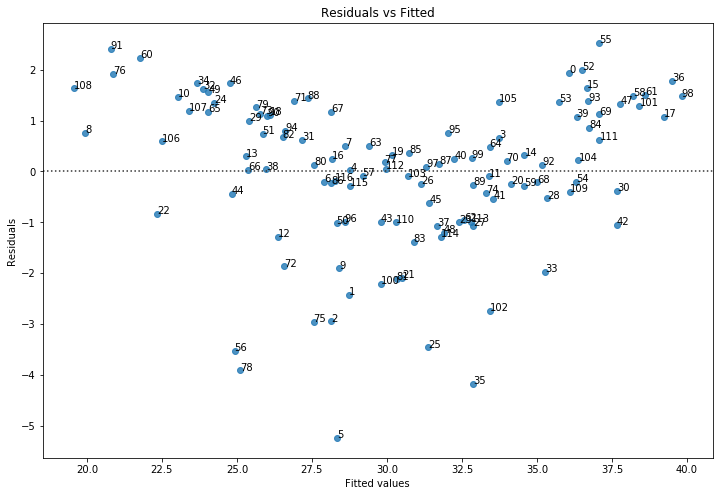

In [47]:
## remove point with highest residual from our data
mask = np.argmax(y_resid)

X = X[mask + 1,:] + X[:mask, :]
y = y[:mask] + y[mask + 1]

## train another linear regression model
model = LinearRegression().fit(X, y)

y_pred = model.predict(X)
y_resid = y - y_pred

plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

## use residplot from seaborn to draw the residual plot
plot_lm_1.axes[0] = sns.residplot(y_pred, y_resid)

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
for i in range(len(y)):
    plot_lm_1.axes[0].annotate(i, 
                               xy=(y_pred[i], 
                                   y_resid[i]));

In [56]:
# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

kcv = KFold(n_splits=5, shuffle=True)
parameters = {'alpha':np.logspace(-3, 3, 7)}
model = Ridge()
score = 0

# Evaluate model by 5 fold cross validation
for train_index, test_index in kcv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ## Use GridSearchCV to select regularization constant
    cmodel = GridSearchCV(model, parameters, cv=5)
    cmodel.fit(X_train, y_train.ravel())
    
    ## Train Ridge on traning data using the selected regularization constant
    model = Ridge(cmodel.best_params_['alpha'])
    model.fit(X_train, y_train)
    
    score += model.score(X_test, y_test)

print('Model score', score/5)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model score 0.9047286694532686


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
